In [1]:
library(dplyr, warn = FALSE)
library(ggplot2, warn = FALSE)
library(forcats, warn = FALSE)

In [10]:
orders <- read.csv("../data/processed-data/medium_orders.csv")
cart_sizes <- read.csv("../data/processed-data/medium.carts.csv")
departments <- read.csv("../data/raw-data/departments.csv")

In [11]:
head(orders, n = 10)

,order_id,product_id,add_to_cart_order,department_id
,<int>,<int>,<int>,<int>
1,5,13176,1,4
2,5,15005,2,13
3,5,47329,3,20
4,5,27966,4,4
5,5,23909,5,16
6,5,48370,6,17
7,5,13245,7,7
8,5,9633,8,6
9,5,27360,9,12


In [12]:
head(cart_sizes)

,order_id,cart_size,distinct_departments
,<int>,<int>,<int>
1,1564244,145,12
2,790903,137,11
3,61355,127,11
4,2970392,121,15
5,2069920,116,9
6,3308010,115,11


In [33]:
head(departments)

,department_id,department
,<int>,<chr>
1,1,frozen
2,2,other
3,3,bakery
4,4,produce
5,5,alcohol
6,6,international


### Prepare column add_to_cart_normalized
description TODO

**Info:**
Here we constder medium orders, which are orders placed in top 40% in terms of cart size and has products from minimum 6 distinct departments.
Minimum cart size here is 26.

In [14]:
full_orders <- orders %>%
    inner_join(cart_sizes, by = "order_id", relationship = "many-to-one") %>%
    inner_join(departments, by = "department_id", relationship = "many-to-one") %>%
    select(-department_id, -distinct_departments) %>%
    mutate(add_to_cart_normalized = (add_to_cart_order-1) / (cart_size-1))
head(full_orders, n = 26)

,order_id,product_id,add_to_cart_order,cart_size,department,add_to_cart_normalized
,<int>,<int>,<int>,<int>,<chr>,<dbl>
1,5,13176,1,26,produce,0.00
2,5,15005,2,26,pantry,0.04
3,5,47329,3,26,deli,0.08
4,5,27966,4,26,produce,0.12
5,5,23909,5,26,dairy eggs,0.16
6,5,48370,6,26,household,0.20
7,5,13245,7,26,beverages,0.24
8,5,9633,8,26,international,0.28
9,5,27360,9,26,meat seafood,0.32


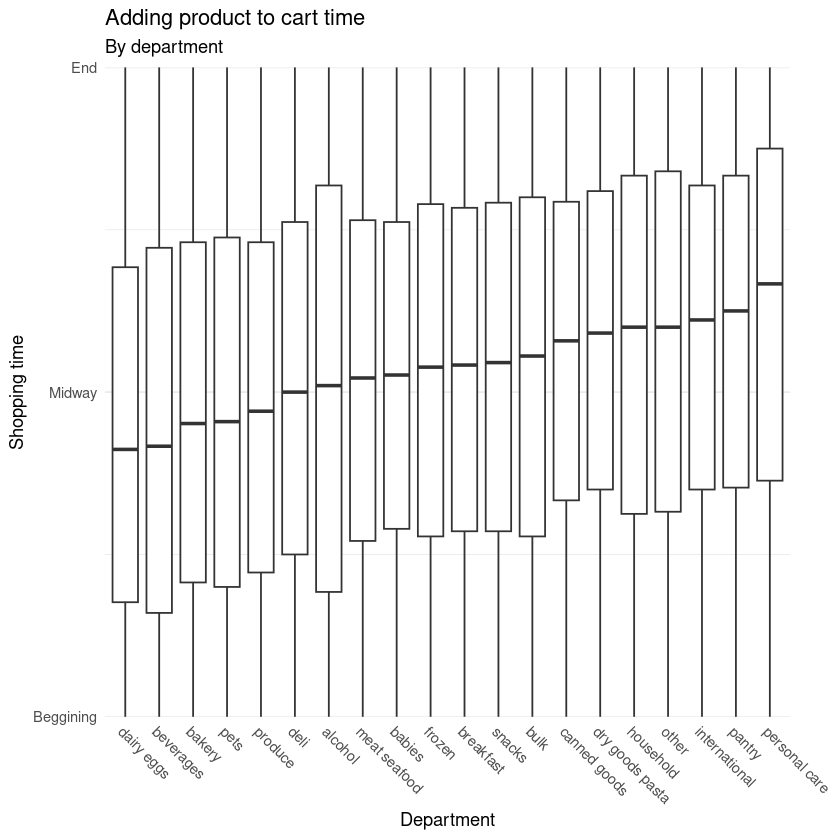

In [30]:
ggplot(filter(full_orders, department != "missing"),
       mapping = aes(x = fct_reorder(department,
                                     add_to_cart_normalized),
                     y = add_to_cart_normalized)) +
    geom_boxplot() +
    labs(x = "Department",
           y = "Shopping time",
           title = "Adding product to cart time",
           subtitle = "By department") +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 1),
        breaks = seq(0, 1, by = 0.5),
        labels = c("Beggining", "Midway", "End")) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = -45, hjust = 0),
         plot.margin = margin(5.5, 30, 5.5, 5.5))

We can see that products of each category were added to cart as well in the begginng of shopping as in the end. However we can draw a conlusion. Over half of products from departments "dairy eggs", "beverages", "bakery", "pets" and "produce" where added before midway of the shopping and much more than half of products from departments "personal care" and "pantry" were bought after that time.

Now we will consider bigger orders. We will use carts with sizes over 80. There are about 10k such orders.

In [7]:
nrow(filter(full_orders, cart_size > 80))

[1] 10228

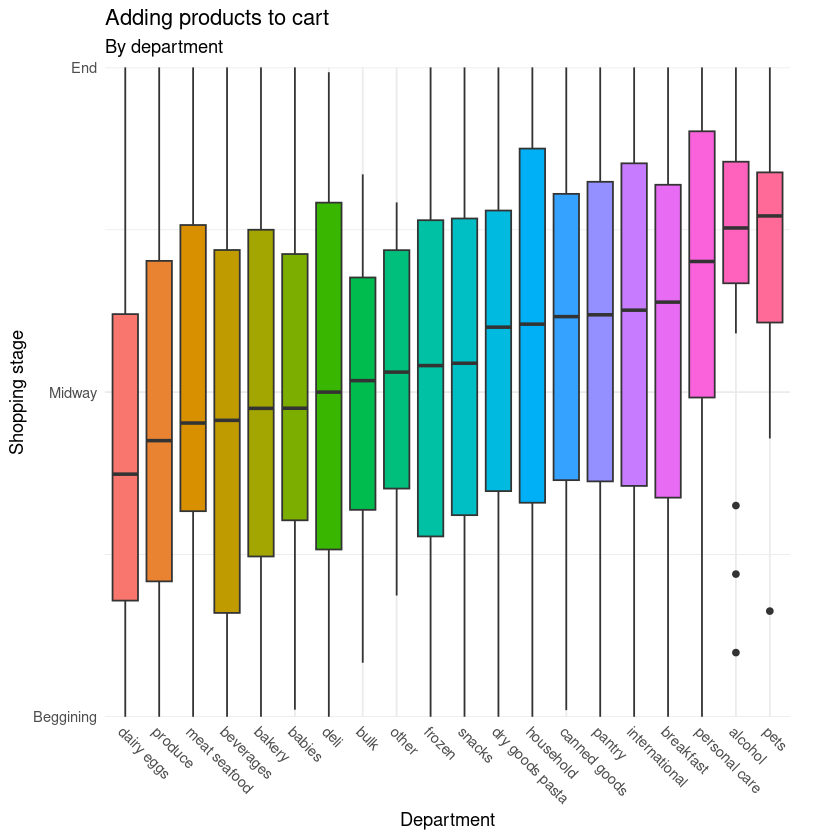

In [43]:
ggplot(filter(full_orders, cart_size > 80, department != "missing"),
       mapping = aes(x = fct_reorder(department,
                                     add_to_cart_normalized),
                     y = add_to_cart_normalized,
                     fill = fct_reorder(department,
                                        add_to_cart_normalized))) +
    geom_boxplot() +
    labs(x = "Department",
           y = "Shopping stage",
           title = "Adding products to cart",
           subtitle = "By department") +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 1),
        breaks = seq(0, 1, by = 0.5),
        labels = c("Beggining", "Midway", "End")) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = -45, hjust = 0),
          plot.margin = margin(5.5, 30, 5.5, 5.5),
          legend.position = "none")

In [44]:
ggsave("../plots/add_product_to_cart_time.png")

Saving 6.67 x 6.67 in image


Let's limit ourselves to products that are usually purchased in large orders. We will consider departments: "dairy & eggs", "produce", "beverages", "dry goods & pasta", "snacks", "meat & seafood", "breakfast" and "deli"

In [35]:
full_orders %>%
    filter(cart_size > 80,
           department %in% departments_limit) %>%
     nrow()

[1] 7659

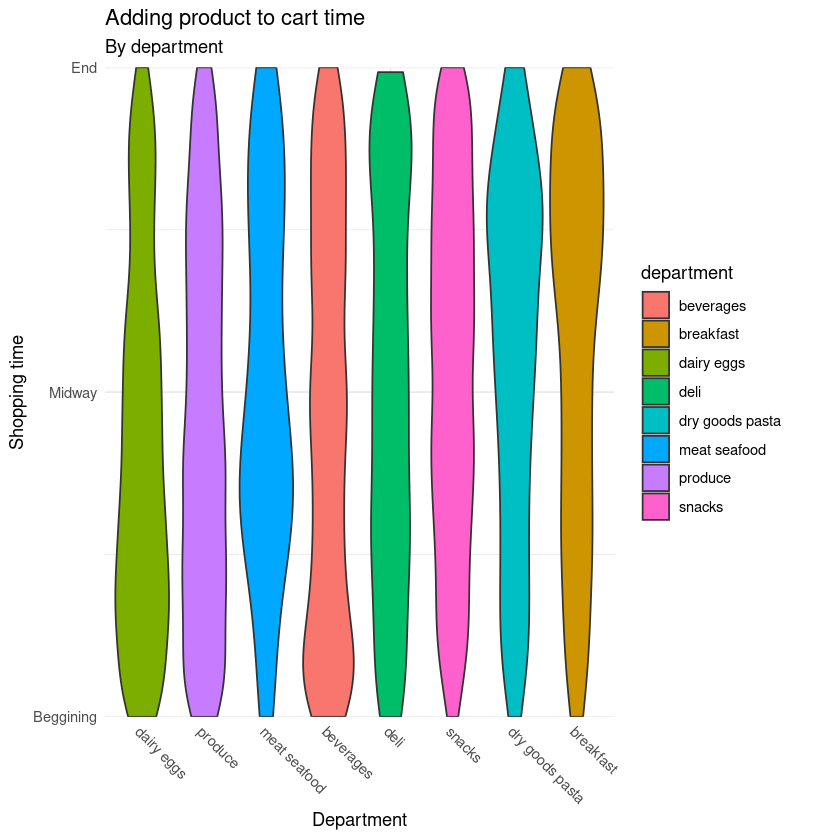

In [39]:
departments_limit <- c("dairy eggs", "produce", "beverages", "dry goods pasta", "snacks", "meat seafood", "breakfast", "deli")

full_orders %>%
    filter(cart_size > 80,
           department %in% departments_limit) %>%
    ggplot(mapping = aes(x = fct_reorder(department,
                                         add_to_cart_normalized),
                         y = add_to_cart_normalized,
                         fill = department)) +
        geom_violin() +
        labs(x = "Department",
               y = "Shopping time",
               title = "Adding product to cart time",
               subtitle = "By department") +
        scale_y_continuous(
            expand = c(0, 0),
            limits = c(0, 1),
            breaks = seq(0, 1, by = 0.5),
            labels = c("Beggining", "Midway", "End")) +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = -45, hjust = 0),
             plot.margin = margin(5.5, 30, 5.5, 5.5))

Saving 6.67 x 6.67 in image
